# SVM을 사용한 얼굴 검출

- 런타임 유형: 하드웨어 가속기=None

- 출처: https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html
- modified by 김보연

In [2]:
from skimage import data, color, feature
import skimage.data
import matplotlib.pyplot as plt
import numpy as np

# 영상과 filter 개념

- https://scikit-image.org/docs/stable/api/skimage.data.html

Text(0.5, 1.0, 'input image')

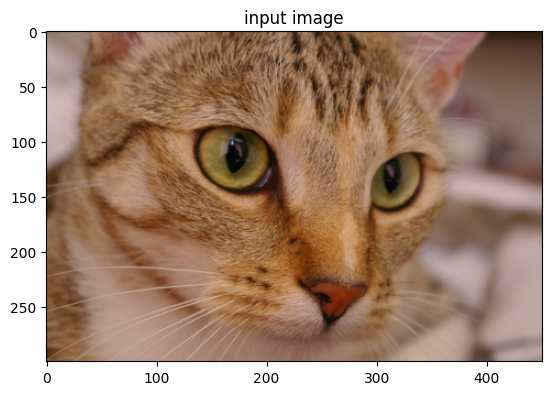

In [3]:
image = data.chelsea()
plt.imshow(image)
plt.title('input image')

- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

0.1856297873018775 0.0 0.015120784313725492 0.7556109803921569
<class 'numpy.ndarray'> (153090,) [0.02976316 0.         0.         0.00844104 0.22233104]


Text(0.5, 1.0, 'Visualization of HOG features')

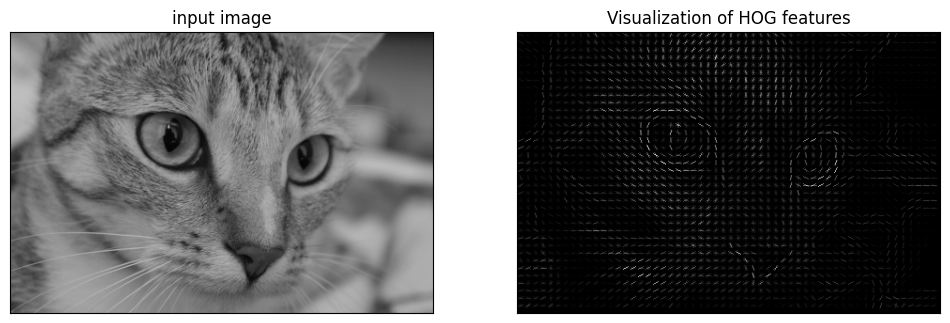

In [5]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_image = feature.hog(image, visualize=True)

print(hog_image.max(), hog_image.min(), image.min(), image.max())
print(type(hog_vec), hog_vec.shape, hog_vec[:5])

fig, ax = plt.subplots(1, 2, figsize=(12, 6), 
                      subplot_kw = dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray', vmin=0, vmax=1)
ax[0].set_title('input image')

ax[1].imshow(hog_image, cmap='gray')
ax[1].set_title('Visualization of HOG features')

#Historam of Gradiant

# 안면 인식 알고리즘 구현: linear SVM 사용

In [6]:
#얼굴 데이터 추출  (최대 1분소요)
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()

In [7]:
#1. 긍정 훈련 표본  
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [9]:
print(type(faces))
print(faces.target_names)
print(faces.images.shape)

<class 'sklearn.utils._bunch.Bunch'>
['AJ Cook' 'AJ Lamas' 'Aaron Eckhart' ... 'Zumrati Juma' 'Zurab Tsereteli'
 'Zydrunas Ilgauskas']
(13233, 62, 47)


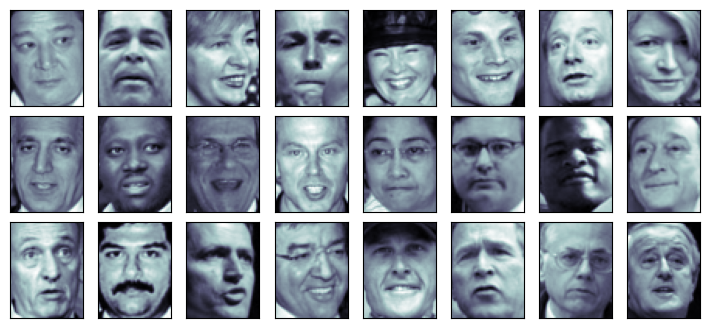

In [12]:
skip = 1000
fig, axes = plt.subplots(3,8, figsize=(9,4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(positive_patches[i+skip], cmap='bone')
plt.show()                            

In [13]:
positive_patches[0].shape

(62, 47)

10


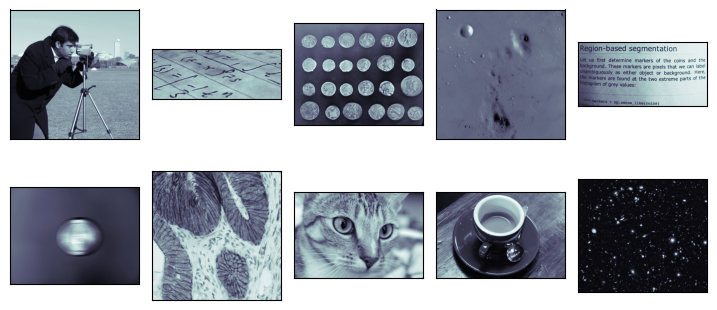

In [15]:
#2. 부정 훈련 표본
from skimage import data, transform
images_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 
                 'immunohistochemistry','chelsea', 'coffee', 'hubble_deep_field']
images = [getattr(data, images_to_use[i])()  for i in range(6)]
images = images + [color.rgb2gray(getattr(data, images_to_use[i])() )       # getattr(object,'name') 이라는 함수는 object라는 오브젝트 내부의 name이라는 멤버를 반환한다.
          for i in range(6, 10)]
print(len(images))

fig, axes = plt.subplots(2,5, figsize=(9,4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))                    
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='bone')
plt.show()

In [17]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = \
     tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                              max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                           for patch in patches])
    #print(patches.shape)
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                            for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

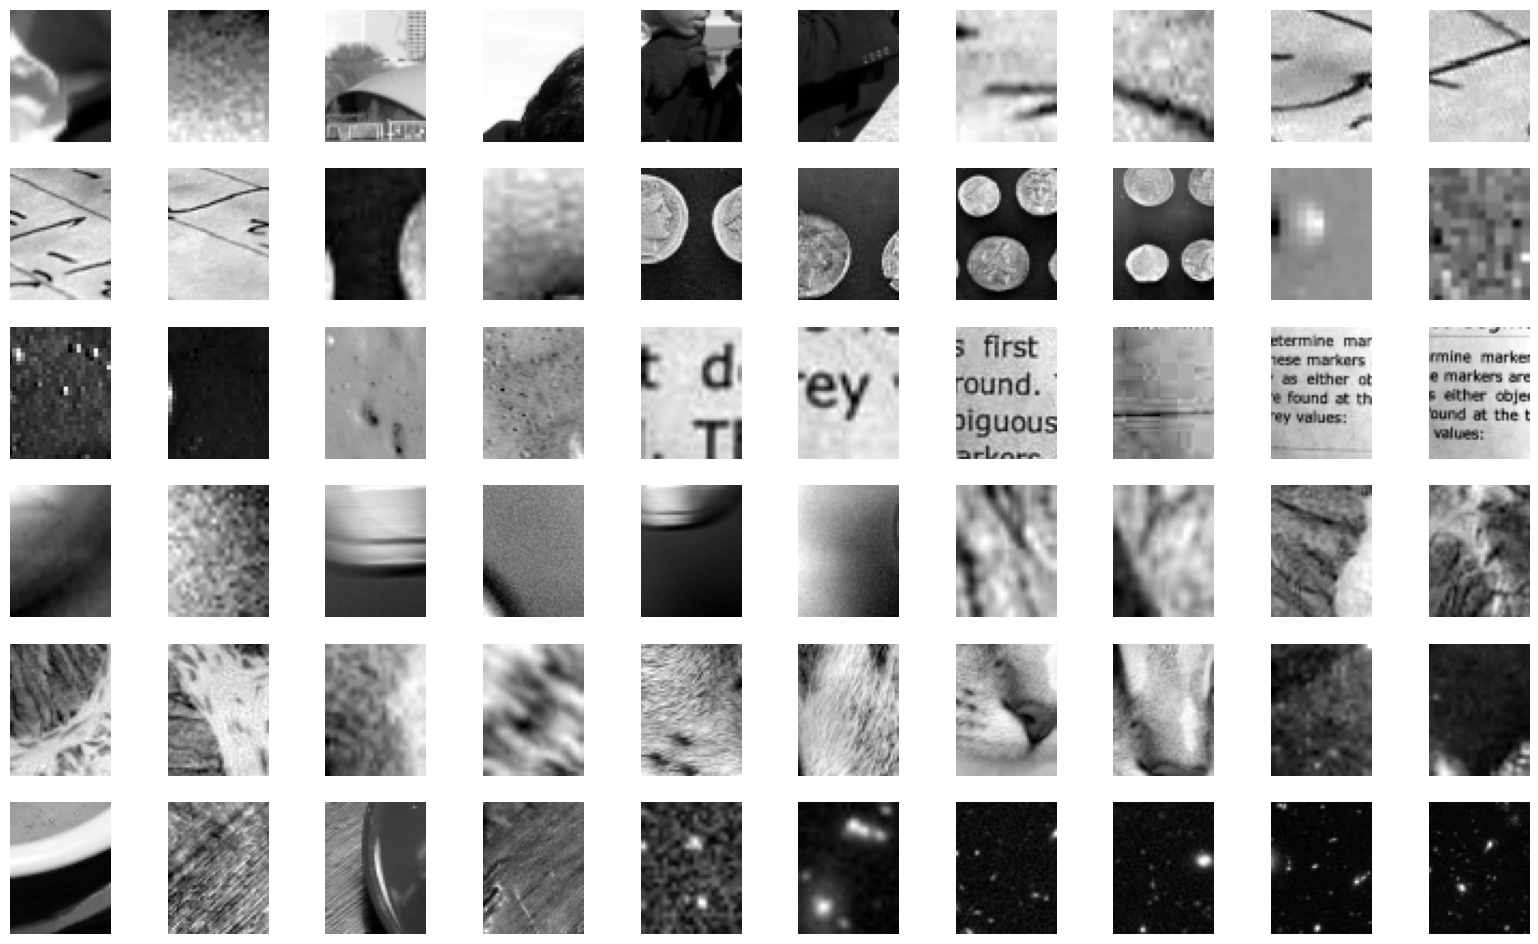

In [18]:
fig, ax = plt.subplots(6, 10, figsize=(20, 12))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500*i], cmap='gray')
    axi.axis('off')

In [21]:
# 집합을 결합하고 HOG 특징 추출
from itertools import chain

X_train = np.array([feature.hog(im)
                   for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [22]:
X_train.shape

(43233, 1215)

In [23]:
# Naive Bayes 의 얼굴 분류 성능
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.95732624, 0.972476  , 0.97340118, 0.97628961, 0.97490169])

In [25]:
np.sum(cross_val_score(GaussianNB(), X_train, y_train))/5

0.9708789450977757

In [26]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C':[1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

0.9885272700574659

- https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

In [27]:
grid.best_params_

{'C': 2.0}

In [28]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0)

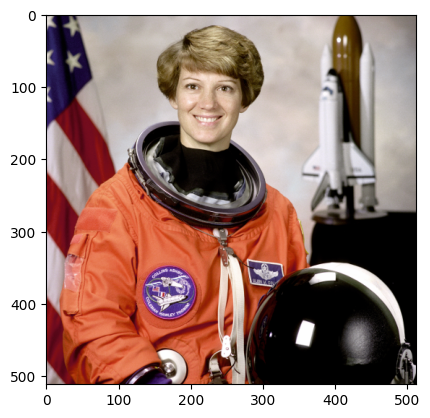

In [31]:
test_image = skimage.data.astronaut()
plt.imshow(test_image)

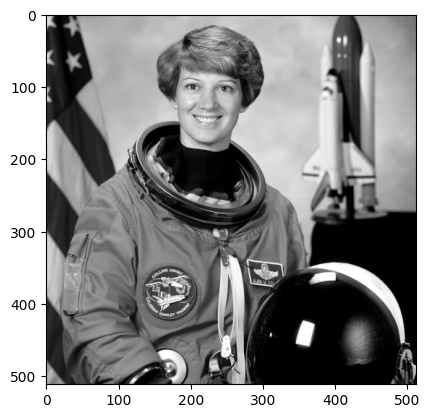

In [32]:
test_image = skimage.color.rgb2gray(test_image)
plt.imshow(test_image, cmap='gray')

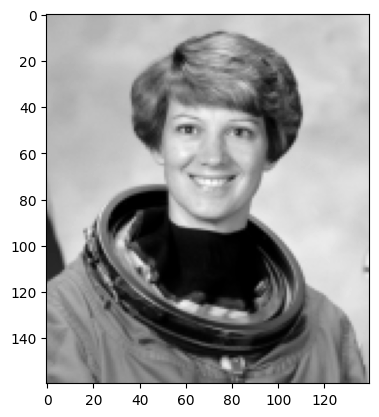

In [35]:
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')

In [38]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                  istep=2, jstep=2):
    
    Ni, Nj = patch_size

    for i in range(0, img.shape[0] - Ni, istep): #Ni:rows
        for j in range(0, img.shape[1] - Nj, jstep):  #Nj:columns
            patch = img[i:i+Ni, j:j+Nj]
            yield (i, j), patch  # generator

In [41]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2303, 1215)

In [42]:
labels = model.predict(patches_hog)
labels.sum()

46.0

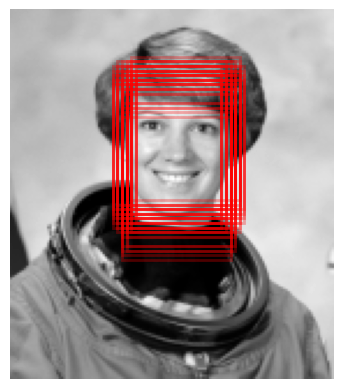

In [46]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

idxList=[]
for i, j in indices[labels ==1 ]:
    ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor='red',
                              alpha=0.3, lw=2, facecolor='none'))
    idxList.append([i,j])   # 사각형의 중앙 위치를 찾기 위함

In [47]:
print(idxList)

[[20, 52], [22, 46], [22, 48], [22, 50], [22, 52], [24, 44], [24, 46], [24, 48], [24, 50], [24, 52], [24, 54], [26, 44], [26, 46], [26, 48], [26, 50], [26, 52], [26, 54], [28, 44], [28, 46], [28, 48], [28, 50], [28, 52], [28, 54], [30, 44], [30, 46], [30, 48], [30, 50], [30, 52], [30, 54], [32, 44], [32, 46], [32, 48], [32, 50], [32, 52], [34, 46], [34, 48], [34, 50], [34, 52], [36, 48], [36, 50], [40, 48], [40, 50], [42, 48], [42, 50], [44, 48], [46, 48]]


In [53]:
idx = np.array(idxList)

In [54]:
idx.mean(axis=0)

array([29.95652174, 48.91304348])

In [55]:
i, j = idx.mean(axis=0).astype(int)
i, j

(29, 48)

In [43]:
Ni, Nj = positive_patches[0].shape
Ni, Nj

(62, 47)

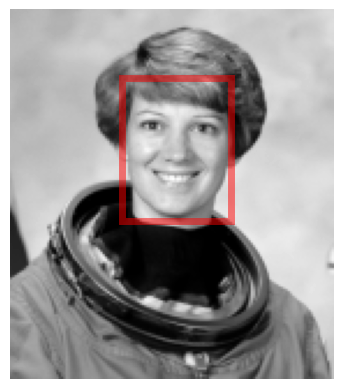

In [56]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
ax.add_patch(plt.Rectangle( (j,i), Nj, Ni, edgecolor='red',
                              alpha=0.5, lw=5, facecolor='none'))
plt.show()

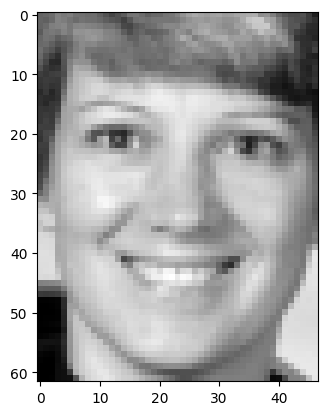

In [57]:
plt.imshow(test_image[ i: i+Ni , j:j+Nj ], cmap='gray')
plt.show()